## VGG16 as simple image classifier

In [8]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers import SGD, Adam

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

__Plot function for later__

In [9]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

__Initialize the VGG16 model__

In [10]:
# load the model
model = VGG16()

__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels.

In [11]:
# load an image from file
image = load_img('../data/img/florence.jpg', target_size=(224, 224))

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [12]:
# convert the image pixels to a numpy array
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [13]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. 

See the paper [here](https://arxiv.org/abs/1409.1556).

In [14]:
# prepare the image for the VGG model
image = preprocess_input(image)

__Predict__

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [15]:
# predict the probability across all output classes
y_pred = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y_pred)

40960/35363 [==================================] - 0s 0us/step


__Inspect most likely labels__

In [16]:
label

[[('n03220513', 'dome', 0.44513696),
  ('n03028079', 'church', 0.3087381),
  ('n03877845', 'palace', 0.049231607),
  ('n02930766', 'cab', 0.026441274),
  ('n02825657', 'bell_cote', 0.02440265)]]

## Retrain on new task

__Import cifar10 data__

We import the regular cifar10 dataset from ```keras``` and normalise.

In [17]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.
testX = testX.astype("float") / 255.

__Resize images__

In [18]:
#trainX = tf.image.resize(trainX, (224,224), preserve_aspect_ratio=True)
#testX = tf.image.resize(testX, (224,224), preserve_aspect_ratio=True)

__Binarize labels__

In [19]:
# integers to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

# initialize label names for CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", 
              "cat", "deer", "dog", "frog", "horse", 
              "ship", "truck"]

__Inspect tensor shape__

In [20]:
trainX.shape

(50000, 32, 32, 3)

__Load VGG16 without classifier layer__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [21]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 2s 0us/step


__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [22]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [23]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [24]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, 
               activation='relu')(flat1)
output = Dense(10, 
               activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

__Compile the new model__

We compile using ADAM and categorical cross-entropy as the loss function.

These parameters can for sure be modified!

In [25]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [27]:
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=256,
              epochs=5,
              verbose=1)

Epoch 1/5
196/196 [==============================] - 220s 1s/step - loss: 1.3194 - accuracy: 0.5448 - val_loss: 1.2796 - val_accuracy: 0.5507
Epoch 2/5
196/196 [==============================] - 175s 893ms/step - loss: 1.2074 - accuracy: 0.5824 - val_loss: 1.2163 - val_accuracy: 0.5753
Epoch 3/5
196/196 [==============================] - 205s 1s/step - loss: 1.1545 - accuracy: 0.5994 - val_loss: 1.1921 - val_accuracy: 0.5807
Epoch 4/5
196/196 [==============================] - 165s 842ms/step - loss: 1.1210 - accuracy: 0.6113 - val_loss: 1.1659 - val_accuracy: 0.5914
Epoch 5/5
196/196 [==============================] - 154s 788ms/step - loss: 1.0904 - accuracy: 0.6230 - val_loss: 1.1567 - val_accuracy: 0.5947


__Evaluate__

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

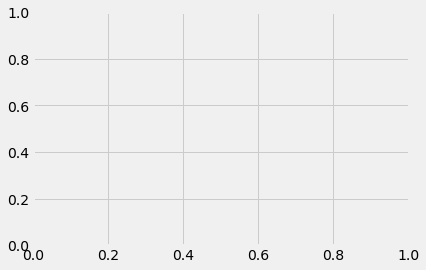

In [28]:
plot_history(H, 10)

In [ ]:
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

## Adding Dropout layers

In [ ]:
tf.keras.backend.clear_session()

# load model without classifier layers
model = VGG16(include_top=False,
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [ ]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, 
               activation='relu')(flat1)
drop1 = Dropout(0.2)(class1)
output = Dense(10, 
               activation='softmax')(drop1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

__Compile__

In [ ]:
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=128,
              epochs=10,
              verbose=1)

Epoch 1/10
391/391 [==============================] - 126s 321ms/step - loss: 1.6579 - accuracy: 0.4169 - val_loss: 1.2845 - val_accuracy: 0.5488
Epoch 2/10
391/391 [==============================] - 130s 333ms/step - loss: 1.2565 - accuracy: 0.5621 - val_loss: 1.2101 - val_accuracy: 0.5735
Epoch 3/10
391/391 [==============================] - 130s 333ms/step - loss: 1.1843 - accuracy: 0.5850 - val_loss: 1.1935 - val_accuracy: 0.5819
Epoch 4/10
391/391 [==============================] - 130s 333ms/step - loss: 1.1438 - accuracy: 0.6025 - val_loss: 1.1562 - val_accuracy: 0.5942
Epoch 5/10
391/391 [==============================] - 132s 338ms/step - loss: 1.1061 - accuracy: 0.6122 - val_loss: 1.1446 - val_accuracy: 0.5968
Epoch 6/10
391/391 [==============================] - 137s 350ms/step - loss: 1.0772 - accuracy: 0.6248 - val_loss: 1.1267 - val_accuracy: 0.6076
Epoch 7/10
391/391 [==============================] - 138s 352ms/step - loss: 1.0535 - accuracy: 0.6365 - val_loss: 1.1040 -

__Evaluate__

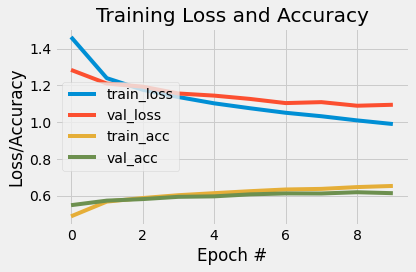

In [26]:
plot_history(H, 10)

In [27]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

              precision    recall  f1-score   support

    airplane       0.66      0.73      0.70      1000
  automobile       0.66      0.71      0.68      1000
        bird       0.53      0.54      0.53      1000
         cat       0.44      0.46      0.45      1000
        deer       0.63      0.45      0.53      1000
         dog       0.54      0.54      0.54      1000
        frog       0.63      0.67      0.65      1000
       horse       0.66      0.69      0.67      1000
        ship       0.75      0.73      0.74      1000
       truck       0.65      0.62      0.63      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



## Use data augmentation

__Reload model__

In [28]:
tf.keras.backend.clear_session()

# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, 
               activation='relu')(flat1)
drop1 = Dropout(0.2)(class1)
output = Dense(10, 
               activation='softmax')(drop1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# compile
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize*
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [29]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip=True)

We're choosing to generate data on the fly, rather than save it to a folder.

In [30]:
# compute quantities required for featurewise normalization
datagen.fit(trainX)
# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(trainX, trainY, batch_size=128),
                            validation_data=(testX, testY),
                            epochs=10)

Epoch 1/10
391/391 [==============================] - 141s 359ms/step - loss: 1.6625 - accuracy: 0.4130 - val_loss: 1.2677 - val_accuracy: 0.5567
Epoch 2/10
391/391 [==============================] - 139s 356ms/step - loss: 1.2512 - accuracy: 0.5643 - val_loss: 1.2102 - val_accuracy: 0.5821
Epoch 3/10
391/391 [==============================] - 145s 372ms/step - loss: 1.1866 - accuracy: 0.5855 - val_loss: 1.1733 - val_accuracy: 0.5883
Epoch 4/10
391/391 [==============================] - 135s 344ms/step - loss: 1.1388 - accuracy: 0.6016 - val_loss: 1.1519 - val_accuracy: 0.5976
Epoch 5/10
391/391 [==============================] - 138s 353ms/step - loss: 1.1132 - accuracy: 0.6123 - val_loss: 1.1427 - val_accuracy: 0.6003
Epoch 6/10
391/391 [==============================] - 130s 333ms/step - loss: 1.0831 - accuracy: 0.6208 - val_loss: 1.1204 - val_accuracy: 0.6061
Epoch 7/10
391/391 [==============================] - 69s 177ms/step - loss: 1.0561 - accuracy: 0.6318 - val_loss: 1.1103 - 

__Inspect__

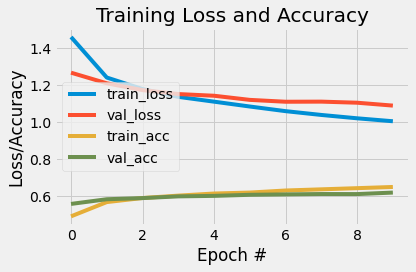

In [31]:
plot_history(H, 10)

In [32]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

              precision    recall  f1-score   support

    airplane       0.69      0.72      0.71      1000
  automobile       0.67      0.69      0.68      1000
        bird       0.55      0.50      0.53      1000
         cat       0.47      0.42      0.45      1000
        deer       0.62      0.49      0.55      1000
         dog       0.52      0.59      0.55      1000
        frog       0.64      0.66      0.65      1000
       horse       0.64      0.73      0.68      1000
        ship       0.74      0.75      0.74      1000
       truck       0.61      0.65      0.63      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000

